# **Lecture 3.8. Shallow NN PyTorch Autodiff**



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Importing the necessary libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from datetime import datetime
from pathlib import Path
import plotly.io as pio
pio.renderers.default = 'colab'

We will be using W&B for visualization.

In [3]:
# Install wandb and update it to the latest version
!pip install wandb --upgrade

     |████████████████████████████████| 1.7 MB 6.9 MB/s 
     |████████████████████████████████| 139 kB 58.5 MB/s 
     |████████████████████████████████| 180 kB 61.8 MB/s 
     |████████████████████████████████| 97 kB 6.8 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=ddef3d6486b0d029922532e2bbab880712ecb0c6a93631ff47d4bcb55598c467
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=f32610de7c21a57e927cc64a6e9e7c867c605b290609534d951648f32c5ff451
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [4]:
# Import wandb
import wandb

# Login to W&B
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Initialize a new project.

In [5]:
# Initialize a new project
wandb.init(name = "L_3_6_final", project = 'DL_Course_intro', id ='l36final21sep')

wandb: Currently logged in as: ymegan (use `wandb login --relogin` to force relogin)


Now, let's implement the a shallow neural network for the Fashion-MNIST dataset.

## Summary Shallow NN

**Let us summarize Shallow Neural Network Model:**

- **Input**: Features X, shape: (n x d)
  - n : number of examples (batch size).
  - d : number of features in each example.

- **Hidden layer** H, shape : (n x h)
  - n : number of examples (batch size).
  - h : number of nurons (features for hidden layer).
 - **Parameters for Hidden layers** $W_1 (h, d)$ and $b_1 (1, h)$

- **Output**: Labels y = {1, 2....K}, shape: (n x K)
    - n : number of examples (batch size).
    - K : number of nurons (number of classes).

 - **Parameters for Hidden layers** $W_2 (K, h)$ and $b_1 (1, K)$
- **Forward pass**

**Hidden layer Output**
$$h_k^{(i)}  = Activation(\mathbf{x^{(i)}}\mathbf{w_k} ^T+b_k)$$

Activation is a non-linear function like ReLU discused above

**Output Layer Output** 

$$o_k^{(i)}  = \mathbf{h^{(i)}}\mathbf{w_k} ^T+b_k$$
$$\hat{p_k}^{(i)} = softmax(o_k^{(i)}) = \frac{e^{o_k^{(i)}}}{\sum_{j=1}^{K} e^{o_j^{(i)}}}$$

<br>

**Image for Batch Size of 1**

<img src = "https://drive.google.com/uc?export=view&id=1X5_WqKa1JCDRhTpd8fZWVvAfOj3D1ZX-" width =700 >


- **Cross Entropy Loss Function**:  **Just for illustration, we have used batch size of two**
<br>

\begin{equation}
\mathcal{L} = -\frac{1}{m} \sum_{k=1}^{K} \sum_{i=1}^{m} \bigg[y_k^{(i)}log(\hat{p_k}^{(i)}) \bigg]
\end{equation}

<img src = "https://drive.google.com/uc?export=view&id=1xY1MvAEjICGqcPyQfDb19hJ0gad-Ox2E" width =600 >






## **Fashion-MNIST Dataset**

Fashion-MNIST dataset consists of images from 10 categories, each represented by 6000 images in the training dataset and by 1000 in the test dataset. Thus, train set contains 60000 images and test set 10000 images.

All the images are grayscale with dimensions 28 x 28.

Categories present in the dataset: t-shirt, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot.

Let us download the dataset using some built-in functions.

We will first convert the images in the dataset to pytorch tensors using torchvision.transforms and then normalize them.

Next, we will use torchvision.datasets for downloading the fashion MNIST  datasets and apply transform that we defines earlier. 

- `trainset` conains the training data
- `testset` contains the testing data

In [6]:
data_folder = Path('/content/drive/MyDrive/Data/DL')

### Train and Test Dataset

In [7]:
# Transform to convert images to pytorch tensors and normalize the data
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download the training data
trainset = torchvision.datasets.FashionMNIST(root = data_folder, 
                                             train = True, 
                                             transform = trans, 
                                             download = True)

# Download the testing data
testset = torchvision.datasets.FashionMNIST(root = data_folder, 
                                            train = False, 
                                            transform = trans, 
                                            download = True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)



#### Check inputs

In [ ]:
# Shape of training data
trainset.data.shape

torch.Size([60000, 28, 28])

In [ ]:
# Shape of testing data
testset.data.shape

torch.Size([10000, 28, 28])

Our train dataset has 60000 images of size 28 x 28 and our test dataset has 10000 images of size 28 x 28.

In [ ]:
# check the max value of inputs
trainset.data.max()

tensor(255, dtype=torch.uint8)

In [ ]:
# check the min value of inputs
trainset.data.min()

tensor(0, dtype=torch.uint8)

In [ ]:
# check the min value of inputs
trainset.data.float().mean()

tensor(72.9404)

#### Check Labels

In [ ]:
# check target values for train set
trainset.targets.shape

torch.Size([60000])

In [ ]:
# Unique Target values
trainset.targets.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

There are 10 different target values or the features present in our dataset.

### Data Loaders

The next step is to create dataloader for train and test set using pytorch dataloader. This will be an iterator that will provide dataset in batches.  Let's keep batch size as 256. 

In [8]:
# Initializing the batch size
batch_size = 256

# Creating data loader for train set
train_loader = torch.utils.data.DataLoader(dataset = trainset, 
                                            batch_size = batch_size, 
                                            shuffle = True)

# Creating data loader for test set
test_loader = torch.utils.data.DataLoader(dataset = testset, 
                                          batch_size = batch_size, 
                                          shuffle = False)


In [ ]:
# check number of batches
len(train_loader)

235

In [ ]:
# check total training examples
len(train_loader.dataset)

60000

In [ ]:
# check imputs and outputs 
for input, target in train_loader:
  print(f'shape of inputs is :{input.shape}')
  print(f'\nmax input value  :{input.max()}')
  print(f'\nmax input value  :{input.min()}')
  print(f'\nmean input value  :{input.mean()}')
  print(f'\nshape of targets is :{target.shape}')
  print(f'\ninputs  :{input}')
  
  break

shape of inputs is :torch.Size([256, 1, 28, 28])

max input value  :1.0

max input value  :-1.0

mean input value  :-0.41257423162460327

shape of targets is :torch.Size([256])

inputs  :tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1.

### Visualize the Data

In [9]:
# Get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# Create grid of images
img_grid = torchvision.utils.make_grid(images[0:50], nrow = 5)

# Logging to W&B
images = wandb.Image(img_grid, caption = "Sample images")
wandb.log({"examples": images})

We have logged some training examples to W&B.

Now, we will start implementing our Softmax Regression Model from scratch.

Just like previous notebooks, we would need to define the following things:

- **Model Parameters**
- **Model**
- **Loss Function** 
- **Optimization Algorithm**

We will discuss each of these in detail.

First let's define labels for our dataset as dataset contains numerical values for now.

### Get Labels

In [10]:
def get_fashion_mnist_labels(labels):  
    """ 
    Function to generate labels.
    Input: numerical labels
    Output: actual string labels
    """


    # Create a list of labels
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

    # Return text_labels according to numerical values
    return [text_labels[int(i)] for i in labels]

### **Model**



In [11]:
def relu(X):
    """ 
    Function to calculate ReLu.
    Input: Tensor
    Output: max(0,x) for all values
    """

    # Create a tensor of zeros with same dimensions as input
    a = torch.zeros_like(X)

    # Return max(0,x) for all elements in the Tensor
    return torch.max(X, a)

In [12]:
def softmax(X):
    """ 
    Function to calculate softmax.
    Input: Tensor.
    Output: Softmax of tensor.
    """
    # Numerator
    X_exp = torch.exp(X)

    # Denominator
    partition = X_exp.sum(1, keepdim = True)

    # Return the softmax value
    return X_exp / partition  

Now, we will define our model which will take an input tensor, flatten it, pass it through ReLU and Softmax function and gives us the predicted value.

In [13]:
def model(X):
    """ 
    Shallow Neural Network.
    Input: Features.
    Output: Predicted labels.
    """
    X = X.reshape((-1, num_inputs))
    fc1 = X @ W1.T + b1 # output from hidden layer, '@' stands for matrix multiplication
    fc1_relu = relu(fc1) # rely activation function on hidden layer
    fc2 = fc1_relu @ W2.T + b2  # output from from output layer
    Output = softmax(fc2) # softmax on final output layer

    return Output

In [14]:
def softmax(output):
    """ 
    Function to calculate softmax.
    Input: Tensor.
    Output: Softmax of tensor.
    """

    # Numerator
    num = torch.exp(output)

    # Denominator
    denom = num.sum(1, keepdim=True)

    # Return the softmax value
    return num / denom  

In [19]:
def one_hot_labels(labels, num_labels, device):
  y = torch.zeros(len(labels), num_labels, device = device)

  for i , l in enumerate(labels):
    y[i][l] = 1

  return y

### **Loss Function**

We will be using cross-entropy loss.





In [15]:
def cross_entropy(ypred, y):
    """ 
    Function to calculate Cross Entropy loss.
    Input: Predicted labels and actual labels.
    Output: Loss.
    """ 
    return - torch.log(ypred[range(len(ypred)), y] + 1e-7).mean()

### **Optimization Algorithm**

We will use stochastic gradient descent to update the parameters.

### **Function for Training and Validation Loops**

**Model Training** involves five steps: 

- Step 0: Randomly initialize parameters / weights
- Step 1: Compute model's predictions - forward pass
- Step 2: Compute loss
- Step 3: Compute the gradients
- Step 4: Update the parameters
- Step 5: Repeat steps 1 - 4

Model training is repeating this process over and over, for many **epochs**.

We will specify number of ***epochs*** and during each epoch we will iterate over the complete dataset and will keep on updating the parameters.

***Learning rate*** and ***epochs*** are known as hyperparameters. We have to adjust the values of these two by hit and try method.

We will now create functions for step 1 to 4.

In [17]:
def train(train_loader, W1, b1, W2, b2, learning_rate, loss_function):

  """ 
  Function for training the model in each epoch
  Input: iterator for train dataset, initial weights and bias, epochs, learning rate.
  Output: final weights, bias, train loss, train accuracy
  """
  # Training Loop loop
  # Initialize train_loss at the he strat of the epoch
  running_train_loss = 0
  running_train_correct = 0
  
  # Iterate on batches from the dataset using train_loader
  for input, targets in train_loader:
    
    # move inputs and outputs to GPUs
    input = input.to(device)
    targets = targets.to(device)

    # Forward pass
    # output = model(input)
    # loss = loss_function(output, targets)

    input = input.reshape((-1, num_inputs))
    fc1 = input @ W1.T + b1
    out_layer1 = relu(fc1)
    fc2 = out_layer1 @ W2.T + b2
    output = softmax(fc2)

    # Correct prediction
    y_pred = torch.argmax(output, dim = 1)
    correct = torch.sum(y_pred == targets)

    # Backward pass
    # loss.backward()
    drelu = out_layer1
    drelu[drelu <= 0] =0
    drelu[drelu >=0]=1

    delta2 = output - one_hot_labels(targets, num_outputs, device = device) #dimensions - no. of classes #deriv of loss with respect to output
    #batch size and number of neurons in the output layer ^^
    delta1 = (delta2 @ W2) * drelu #purpose of storing delta; want to see changes and how weight changes (delta * inputs = change)

    #Update weights ##1/m = 1/len(input)
    W2 -= learning_rate * delta2.T @ out_layer1 * (1/len(input)) #delta2 @ out_layer = W2.bias
    b2 -= learning_rate * delta2.sum(axis = 0) * (1/len(input)) 

    W1 -= learning_rate * delta1.T @ input * (1/len(input))
    b1 -= learning_rate * delta1.sum(axis = 0) * (1/len(input))
    # Update parameters using their gradient
    with torch.no_grad():

      # Update parameters
      # Hiden layer
      W1.data -= learning_rate * W1.grad
      b1.data -= learning_rate * b1.grad    
      # Output layer
      W2.data -= learning_rate * W2.grad
      b2.data -= learning_rate * b2.grad 

      # set gradients to zero
      # hidden layer
      W1.grad.zero_() 
      b1.grad.zero_()   
      # output layer
      W2.grad.zero_() 
      b2.grad.zero_()
          
    # Add train loss of a batch 
    running_train_loss += loss.item()

    # Add Corect counts of a batch
    running_train_correct += correct
  
  # Calculate mean train loss for the whole dataset for a particular epoch
  train_loss = running_train_loss/len(train_loader)

  # Calculate accuracy for the whole dataset for a particular epoch
  train_acc = running_train_correct/len(train_loader.dataset)

  return W1, b1, W2, b2, train_loss, train_acc

In [ ]:
def validate(test_loader, W1, b1, W2, b2, loss_function):

  """ 
  Function for training the model and plotting the graph for train & test loss vs epoch.
  Input: iterator for train dataset, initial weights and bias, epochs, learning rate, batch size.
  Output: final weights, bias and train loss and test loss for each epoch.
  """

  # Validation loop
  # Initialize train_loss at the he strat of the epoch
  running_test_loss = 0
  running_test_correct = 0
  
  with torch.no_grad():
    for input,targets in test_loader:

      # move inputs and outputs to GPUs
      input = input.to(device)
      targets = targets.to(device)

      # Forward pass
      output = model(input)
      loss = loss_function(output,targets)

      # Correct Predictions
      y_pred = torch.argmax(output, dim = 1)
      correct = torch.sum(y_pred == targets)

      # Add test loss of a batch 
      running_test_loss += loss.item()

      # Add correct count for each batch
      running_test_correct += correct

    # Calculate mean test loss for the whole dataset for a particular epoch
    test_loss = running_test_loss/len(test_loader)

    # Calculate accuracy for the whole dataset for a particular epoch
    test_acc = running_test_correct/len(test_loader.dataset)
    
  return test_loss, test_acc

### **Initialize Model Parameters**

We will initialize the values for weights and bias. Weights will be a tensor of `size: (number of outputs x number of inputs)`. 

Here, input is an image with `dimensions: 1 X 28 x 28 `. Thus the number of features in each image will be `784`.

Thus for hidden layer, num of outputs = 256 and inputs = 784

Finally,  number of outputs will be equal to the number of classes as we would require probability for each class. So, it would be `10 for 10 different classes`.
Thus for output layer , num of inputs = 256 and outputs = 10



In [20]:
# device 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize number of inputs (features: 28 X 28 X 1) and outputs (labels: 10)
num_inputs = 784
num_hidden = 256
num_outputs = 10


# Initialize weights from normal distribution with mean 0 and standard deviation 0.01
W1 = torch.normal(0, 0.01, size = (num_hidden, num_inputs), device = device, requires_grad = False )
# W1.requires_grad_()

# Initialize bias with zeros
b1 = torch.zeros(num_hidden, device = device, requires_grad = False)
# b1.requires_grad_()

# Initialize weights from normal distribution with mean 0 and standard deviation 0.01
W2 = torch.normal(0, 0.01, size = (num_outputs, num_hidden), device = device,  requires_grad = False )
#W1.requires_grad_()

# Initialize bias with zeros
b2 = torch.zeros(num_outputs, device = device, requires_grad = False)
# b2.requires_grad_()

# Initialize number of epochs, learning rate and batch size
epochs = 10
learning_rate = 0.05

loss_function = cross_entropy

Now, we will initilize the values for epochs, learning rate and batch size and start training our model on train dataset.

### Model Training


In [ ]:
# Create lists to store train and test loss at each epoch
train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []

# Iterate for the given number of epochs
for epoch in range(epochs):

  # Get train loss and accuracy for one epoch
  W1, b1, W2, b2, train_loss, train_acc = train(train_loader, W1, b1, W2, b2,  learning_rate, loss_function)
  test_loss, test_acc   = validate(test_loader, W1, b1, W2, b2, loss_function)

  # Save history of the Losses and accuracy
  train_loss_history.append(train_loss)
  train_acc_history.append(train_acc)

  test_loss_history.append(test_loss)
  test_acc_history.append(test_acc)

  # Log the train and test loss to W&B
  wandb.log({f"Train Loss :": train_loss})
  wandb.log({f"Train Acc :": train_acc})

  wandb.log({f"Test Loss :": test_loss})
  wandb.log({f"Test Acc :": test_acc})


  # Print the train loss and accuracy for given number of epochs, batch size and number of samples
  print(f'Epoch : {epoch+1} / {epochs}')
  print(f'Train Loss: {train_loss : .4f} | Train Accuracy: {train_acc * 100 : .4f}%')
  print(f'Test Loss: {test_loss : .4f} | Test Accuracy: {test_acc * 100 : .4f}%')
  print()


Epoch : 1 / 10
Train Loss:  0.9312 | Train Accuracy:  69.4400%
Test Loss:  0.6112 | Test Accuracy:  77.4200%

Epoch : 2 / 10
Train Loss:  0.5433 | Train Accuracy:  80.6117%
Test Loss:  0.5404 | Test Accuracy:  79.8800%

Epoch : 3 / 10
Train Loss:  0.4818 | Train Accuracy:  82.8117%
Test Loss:  0.5030 | Test Accuracy:  81.2600%

Epoch : 4 / 10
Train Loss:  0.4510 | Train Accuracy:  83.9950%
Test Loss:  0.4760 | Test Accuracy:  83.2300%

Epoch : 5 / 10
Train Loss:  0.4295 | Train Accuracy:  84.7067%
Test Loss:  0.4717 | Test Accuracy:  82.5400%

Epoch : 6 / 10
Train Loss:  0.4142 | Train Accuracy:  85.2083%
Test Loss:  0.4348 | Test Accuracy:  83.9200%

Epoch : 7 / 10
Train Loss:  0.4007 | Train Accuracy:  85.6417%
Test Loss:  0.4339 | Test Accuracy:  84.2200%

Epoch : 8 / 10
Train Loss:  0.3879 | Train Accuracy:  86.1933%
Test Loss:  0.4265 | Test Accuracy:  84.2000%

Epoch : 9 / 10
Train Loss:  0.3790 | Train Accuracy:  86.4617%
Test Loss:  0.4224 | Test Accuracy:  84.7000%

Epoch : 10

We can observe that with each epoch, our loss is getting reduced hence our softmax regression model is able to classify appropriately.

In [ ]:
# Plot the train loss and test loss per iteration
fig = plt.figure(0)
plt.plot(train_loss_history, label = 'train loss')
plt.plot(test_loss_history, label = 'test loss')
plt.legend()

# Log the plot to W&B
wandb.log({"train-test loss per epoch": fig})

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



You can observe from the graphs logged to W&B how the loss is decreasing while training.

### **Accuracy and Predictions**

Now we have final values for weights and bias after training the model. We will use these values to make predictions on the test dataset.

In [ ]:
def get_acc_pred(data_loader, W1, b1, W2, b2):
  """ 
  Function to get predictions for a given test set and calculate accuracy.
  Input: Iterator to the test set.
  Output: Prections and Accuracy for test set.
  """
  with torch.no_grad():
    # Array to store predicted labels
    predictions = torch.Tensor()
    predictions = predictions.to(device)

    # Array to store actual labels
    y = torch.Tensor()
    y = y.to(device)
    # Iterate over batches from test set
    for input, targets in data_loader:
      
      # move inputs and outputs to GPUs
      input = input.to(device)
      targets = targets.to(device)

      # Calculated the predicted labels
      output = model(input)

      # Choose the label with maximum probability
      indices = torch.argmax(output, dim = 1)

      # Add the predicted labels to the array
      predictions = torch.cat((predictions, indices)) 

      # Add the actual labels to the array
      y = torch.cat((y, targets)) 

    # Check for complete dataset if actual and predicted labels are same or not
    # Calculate accuracy
    acc = (predictions == y).float().mean()

  # Return array containing predictions and accuracy
  return predictions, acc
  

In [ ]:
predictions_train, acc_train = get_acc_pred(train_loader, W1, b1, W2, b2)

# Get the prediction and accuracy for the test dataset
predictions, acc_test = get_acc_pred(test_loader, W1, b1, W2, b2)

In [ ]:
# Print Accuracy for train dataset
print(acc_train * 100)

# Print Accuracy for test dataset
print(acc_test * 100)

tensor(86.6633, device='cuda:0')
tensor(84.9000, device='cuda:0')


**We have obtained 85.4% accuracy on train dataset and 83.67% accuracy on test dataset.**


## **Visualizations on Predictions**

Now, we will make some visualizations for the predictions that we obtained.

We will construct a `confusion matrix` which will help us to visualize the performance of our classification model on the test dataset as we know the true values for the test data.

In [ ]:
# Get an array containing actual labels
testing_labels = testset.targets.numpy()

In [ ]:
# Import libraries for building the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# Define the values for classes
classes = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
           'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']


In [ ]:

# Log a confusion matrix to W&B
wandb.log({"conf_mat" : wandb.plot.confusion_matrix(
                        probs = None,
                        y_true = testing_labels,
                        preds = predictions.to('cpu').numpy(),
                        class_names = classes)})


Let us look at some of the images from test class and see the actual and predicted labels.

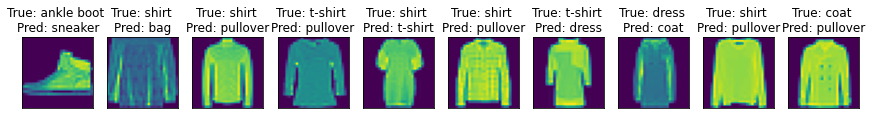

In [ ]:
# Initialize number of images to be displayed
n = 10

# Convert predictions to integer numpy array
predictions = predictions.to('cpu').numpy()
predictions = predictions.astype(np.int)

# Get some random misclassified images
misclassified_idx = np.argwhere(predictions != testing_labels).flatten()

# Select indexed for 10 random misclassified images
i = np.random.choice(misclassified_idx, n)

# Get the actual and predicted labels for the 10 misclassified images
trues = get_fashion_mnist_labels(testing_labels[i])
preds = get_fashion_mnist_labels(predictions[i])

# Zip the actual and predicted labels to be used further
titles = [true +'\n' + pred for true, pred in zip(trues, preds)]

# Store the 10 images to be displayed in the format of 28 x 28
images = testset.data[i].view(n, 28, 28)

# Plot the images
fig = plt.figure(figsize = (15, 65))
for idx in np.arange(n):
    ax = fig.add_subplot(1, 10, idx+1, xticks = [], yticks = [])
    plt.imshow(images[idx])
    ax.set_title("True: {0} \nPred: {1}".format(trues[idx], preds[idx]))

# Log the plot to W&B
wandb.log({"Misclassifications": fig})


Here, we can observe that most of the items were misclassified because of the similarities in their features.